In [3]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Utiliser Fast Text pour le carractere embedding

#1 Prepare data

In [31]:
#donne les index de seq et les mets dans un tensor
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[seq]]
    return torch.tensor(idxs, dtype=torch.long)

#affiche
def affiche(losses_eval, losses_train):
    plt.plot(np.arange(0,len(losses_eval)),losses_eval)
    plt.title('Evolution loss evaluation set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(np.arange(0,len(losses_train)),losses_train)
    plt.title('Evolution loss train set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [5]:
data_file = open('pos_reference.txt.lima', 'r')
data = []
word_to_ix = {}
tag_to_ix = {}

for line in data_file : 
    # Pour ne pas prendre les lignes vides
    if not line.isspace():

        # On retire les retours chariots à la fin des lignes + separation du mot et de sa forme morpho-syntaxique dans un tuple
        wordAndToken = line.rstrip('\n').split('\t')

        # Si le mot n'est pas dans le dico on l'ajoute avec son index qui est la taille actuelle du dico
        if wordAndToken[0] not in word_to_ix:
            word_to_ix[wordAndToken[0]] = len(word_to_ix)

        # Pareil pour les tokens
        if wordAndToken[1] not in tag_to_ix:
            tag_to_ix[wordAndToken[1]] = len(tag_to_ix)

        data.append(wordAndToken)

In [6]:
print(tag_to_ix)

{'PROPN': 0, 'COMMA': 1, 'ADJ': 2, 'AUX': 3, 'VERB': 4, 'DET': 5, 'NOUN': 6, 'ADP': 7, 'SENT': 8, 'CONJ': 9, 'ADV': 10, 'PART': 11, 'PRON': 12, 'SCONJ': 13, 'COLON': 14, 'OQU': 15, 'QUOT': 16, 'NUM': 17, 'SYM': 18, 'OPAR': 19, 'CPAR': 20}


In [7]:
#print(word_to_ix)

In [8]:
for i in range(10):
    print(data[i])

['Pierre Vinken', 'PROPN']
[',', 'COMMA']
['61 years old', 'ADJ']
[',', 'COMMA']
['will', 'AUX']
['join', 'VERB']
['the', 'DET']
['board', 'NOUN']
['as', 'ADP']
['a', 'DET']


Séparation des trains set, test set et eval set

In [9]:
nb_line = len(data)
line_80 = round((nb_line*80)/100)
line_10 = round((nb_line*10)/100)  

trainSet = data[:line_80]
testSet = data[line_80+1:line_80+line_10]
evalSet = data[line_80+line_10+1:]



In [10]:
################# Create the model #################
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores



In [11]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

################# Train the model #################
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [12]:
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(trainSet[0][0], word_to_ix)
    print(inputs)
    tag_scores = model(inputs)
    print()
    print("=> Scores before training of the tags affected to each word")
    print(tag_scores)

tensor([0])

=> Scores before training of the tags affected to each word
tensor([[-3.2064, -2.7891, -2.8434, -3.3965, -3.1087, -2.7724, -2.9695, -2.7634,
         -2.8087, -3.5756, -3.6252, -3.4572, -2.9819, -3.4824, -2.9050, -3.4204,
         -3.2272, -2.9646, -2.9617, -2.7491, -2.7737]])


In [33]:
nb_epoch = 300
losses_eval = []
losses_train = []


f1_valid = []

for epoch in range(nb_epoch):  # again, normally you would NOT do 300 epochs, it is toy data
    print("Epoch : " + str(epoch) +'/'+ str(nb_epoch) + '\n')
    
    #On passe le model en phase d'entrainement
    model.train()
    for sentence, tags in trainSet:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in_train = prepare_sequence(sentence, word_to_ix)
        targets_train = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores_train = model(sentence_in_train)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss_train = loss_function(tag_scores_train, targets_train)
        current_loss += loss_train.item()

        loss_train.backward()
        optimizer.step()
    
    mean_train_loss = current_loss/len(evalSet)
    losses_train.append(mean_train_loss)
    print('Train Loss after this epoch : ' + str(mean_train_loss) )
    current_loss = 0.0
    
    model.zero_grad()

    #On passe le model en phase d'evaluation
    model.eval() 
    current_loss = 0.0
    i = 0

    with torch.no_grad():
        for sentence, tags in evalSet:

            sentence_in_eval = prepare_sequence(sentence, word_to_ix)
            targets_eval = prepare_sequence(tags, tag_to_ix)

            tag_scores_eval = model(sentence_in_eval)
            
            loss_eval = loss_function(tag_scores_eval, targets_eval)
            current_loss += loss_eval.item()  
            
        mean_eval_loss = current_loss/len(evalSet)
        losses_eval.append(mean_eval_loss)
        print('Train Loss after this epoch : ' + str(mean_eval_loss) )
        current_loss = 0.0



Epoch : 0/300

Train Loss after this epoch : 3.351524332939211
Train Loss after this epoch : 2.558542058310184
Epoch : 1/300

Train Loss after this epoch : 3.3299853622665156
Train Loss after this epoch : 2.5594656071964503
Epoch : 2/300

Train Loss after this epoch : 3.292776027698365
Train Loss after this epoch : 2.5558993194193587
Epoch : 3/300

Train Loss after this epoch : 3.3332095148477556
Train Loss after this epoch : 2.5372632816444347
Epoch : 4/300

Train Loss after this epoch : 3.298073907641135
Train Loss after this epoch : 2.5565154480420684
Epoch : 5/300

Train Loss after this epoch : 3.2663768996949876
Train Loss after this epoch : 2.5665452108876203
Epoch : 6/300



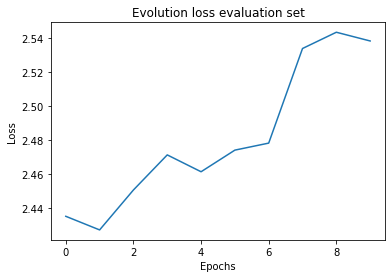

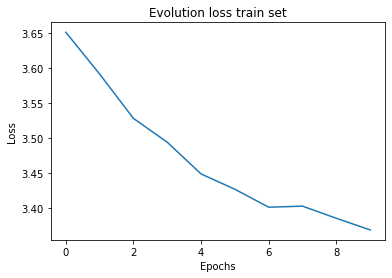

In [32]:
affiche(losses_eval, losses_train)

In [23]:
# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(trainSet[4][0], word_to_ix)
    print()
    print('=> The sentence to analyze (first sentence of the Training data):')
    print(trainSet[4])

    print()
    print("=> Training data: each word is assigned to a unique index:")
    #print(word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!

    print()
    print("=> Scores after training of the tags affected to each word of the sentence to analyze:")
    print(tag_scores)


=> The sentence to analyze (first sentence of the Training data):
['will', 'AUX']

=> Training data: each word is assigned to a unique index:

=> Scores after training of the tags affected to each word of the sentence to analyze:
tensor([[-19.2129,  -5.4328,  -7.1051,  -2.8564,  -7.7279,  -9.3490, -18.2661,
          -3.2206,  -4.9246,  -2.6503,  -2.6695,  -2.5759,  -0.8896,  -1.3630,
          -7.6969,  -7.7346, -10.8664, -16.1910,  -9.1793,  -9.8672,  -5.1453]])


In [ ]:
#Dans le tensor ci-dessus, le score le plus haut correspond au resultat le plus probable.